Script for analysis

In [ ]:
!pip install rioxarray
!pip install geopandas
!pip install cartopy
!pip install xhistogram
!pip install xarrayMannKendall

In [ ]:
#Import packages
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from xhistogram.xarray import histogram
from xarrayMannKendall import *

<ipython-input-3-de665718d1d4>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read in ERA5 data:
data1=xr.open_dataset('/dir/data.nc')
#data1= data1.sel(slice)
data1.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
data1.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (longitude: 261, latitude: 121, time: 996)
Coordinates:
  * longitude    (longitude) float32 -130.0 -129.8 -129.5 ... -65.5 -65.25 -65.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * time         (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, latitude, longitude) float32 ...
    mer          (time, latitude, longitude) float32 ...
    mper         (time, latitude, longitude) float32 ...
    mslhf        (time, latitude, longitude) float32 ...
    msnlwrf      (time, latitude, longitude) float32 ...
    msnswrf      (time, latitude, longitude) float32 ...
    msshf        (time, latitude, longitude) float32 ...
    tp           (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    swvl2        (time, latitude, longitude) float32 ...
    swvl3        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-02 18:29:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
data1

<xarray.Dataset>
Dimensions:      (longitude: 261, latitude: 121, time: 996)
Coordinates:
  * longitude    (longitude) float32 -130.0 -129.8 -129.5 ... -65.5 -65.25 -65.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * time         (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, latitude, longitude) float32 ...
    mer          (time, latitude, longitude) float32 ...
    mper         (time, latitude, longitude) float32 ...
    mslhf        (time, latitude, longitude) float32 ...
    msnlwrf      (time, latitude, longitude) float32 ...
    msnswrf      (time, latitude, longitude) float32 ...
    msshf        (time, latitude, longitude) float32 ...
    tp           (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    swvl2        (time, latitude, longitude) float32 ...
    swvl3        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-02 18:29:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
#isolate summers
def is_summer(month):
    return (month >= 6) & (month <= 8)

In [ ]:
data = data1.sel(time=is_summer(data1['time.month']))
data2=data2.sel(time=is_summer(data2['time.month']))

In [ ]:
#root zone sm calculation
sm = data.swvl1*0.07+data.swvl2*0.21+data.swvl3*0.72
sm=sm.rename('rtsm')
#sm.where(sm>=0)

In [ ]:
#calculate coupling metric
#Lv = (2.5*(10**6))-((2.386*10**3)*(data.t2m-273))
Lv = 1.9184*(10**6)*((data.t2m/(data.t2m-33.91))**2)#
Rn=data.msnswrf+data.msnlwrf
h = Rn - (Lv * (-data.mer))
hp = Rn - (Lv * (-data.mper))
ha = h.groupby("time.month") - h.groupby("time.month").mean("time")
han = ha.groupby("time.month")/ha.groupby("time.month").std("time")
hpa = hp.groupby("time.month") - hp.groupby("time.month").mean("time")
hpan = hpa.groupby("time.month")/hpa.groupby("time.month").std("time")
e=han-hpan
e=e.rename('eb')
sm_def = (-data.mper) - (-data.mer)


In [ ]:
# #plot coupling metric
# (Cp).mean(dim='time').plot()
# data2=Cp

In [ ]:
#import shapefile of US
shape1 = gpd.read_file('/dir/US_shapefile/cb_2018_us_nation_5m.shp', crs="epsg:4326")

In [ ]:
#clip dataset using shapefile
Ps=data.tp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
Ts=data.t2m.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
SMs=sm.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
#CPs=data2.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)

In [ ]:
#clip and average over region
P=data.tp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude'])
T=data.t2m.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude'])
SM=sm.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude'])
H=(h.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude']))
Hp=(hp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude']))

In [ ]:
#Calculate anomalies - of timeseries
P_anom = P.groupby("time.month") - P.groupby("time.month").mean("time")
P_anom_std = P_anom.groupby("time.month")/P_anom.groupby("time.month").std("time")

SM_anom = SM.groupby("time.month") - SM.groupby("time.month").mean("time")
SM_anom_std = SM_anom.groupby("time.month")/SM_anom.groupby("time.month").std("time")

T_anom = T.groupby("time.month") - T.groupby("time.month").mean("time")
T_anom_std = T_anom.groupby("time.month")/T_anom.groupby("time.month").std("time")

H_anom = H.groupby("time.month") - H.groupby("time.month").mean("time")
H_anom_std = H_anom.groupby("time.month")/H_anom.groupby("time.month").std("time")
Hp_anom = Hp.groupby("time.month") - Hp.groupby("time.month").mean("time")
Hp_anom_std = Hp_anom.groupby("time.month")/Hp_anom.groupby("time.month").std("time")

In [ ]:
#calculate anomalies - spatially averaged values
Pa = Ps.groupby("time.month") - Ps.groupby("time.month").mean("time")
Pas = Pa.groupby("time.month")/Pa.groupby("time.month").std("time")

SMa = SMs.groupby("time.month") - SMs.groupby("time.month").mean("time")
SMas = SMa.groupby("time.month")/SMa.groupby("time.month").std("time")

Ta = Ts.groupby("time.month") - Ts.groupby("time.month").mean("time")
Tas = Ta.groupby("time.month")/Ta.groupby("time.month").std("time")

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: Run

In [ ]:
#Calculate coupling metric
Cp=e*Tas


In [ ]:
#isolate dry years (summer averaged)
dry_yrs=P_anom_std.groupby('time.year').mean()
dry_yrs[dry_yrs<-1]

<xarray.DataArray 'tp' (year: 8)>
array([-1.0263089, -1.2309064, -1.3357325, -1.2636788, -1.2004242,
       -1.353764 , -1.0462216, -1.341651 ], dtype=float32)
Coordinates:
  * year     (year) int64 1943 1952 1954 1956 1966 1970 2011 2012

In [ ]:
#Attempt at compound dry hot extreme calculation
d1= xr.ones_like(SM_anom_std)
scdh1 = d1.where((SM_anom_std<-1) & (T_anom_std>1))
pcdh1 = d1.where((P_anom_std<-1) & (T_anom_std>1))
#scdh1=T_anom_std-SM_anom_std
#pcdh1=T_anom_std-P_anom_std
scdh=scdh1.groupby('time.year').count()
pcdh=pcdh1.groupby('time.year').count()
scdh

<xarray.DataArray 'rtsm' (year: 83)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 1, 3, 0, 0, 0, 2, 0, 2, 0, 3, 2, 3])
Coordinates:
  * year     (year) int64 1940 1941 1942 1943 1944 ... 2018 2019 2020 2021 2022

<BarContainer object of 83 artists>

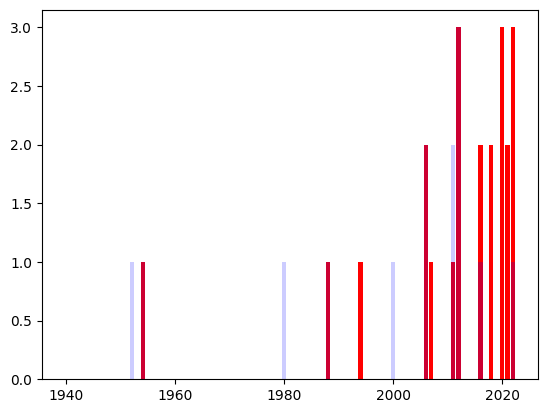

In [ ]:
#plot dry hot extremes (show both based on defining it related to soil moisture and precipitation)
plt.bar(np.arange(1940,2023),scdh,color='red',label='Temp minus Soil Moisture')
plt.bar(np.arange(1940,2023),pcdh,color='blue',alpha=0.2,label='Temp minus Precipitation')

(1940.0, 2023.0)

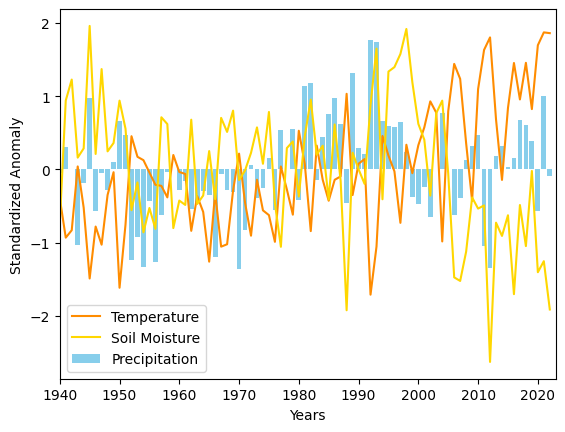

In [ ]:
#Plot whole summer-averaged time series
plt.plot(np.arange(1940,2023),T_anom_std.groupby('time.year').mean(),color='darkorange',label='Temperature')
plt.plot(np.arange(1940,2023),SM_anom_std.groupby('time.year').mean(),color='gold',label='Soil Moisture')
plt.bar(np.arange(1940,2023),P_anom_std.groupby('time.year').mean(),color='skyblue',label='Precipitation')
#plt.plot(np.arange(1940,2023),E_anom_std.groupby('time.year').mean(),color='Purple',label='Coupling')
#plt.bar(P_anom_std.time,P_anom_std)
plt.xlabel('Years')
plt.ylabel('Standardized Anomaly')
plt.legend()
plt.xlim([1940,2023])

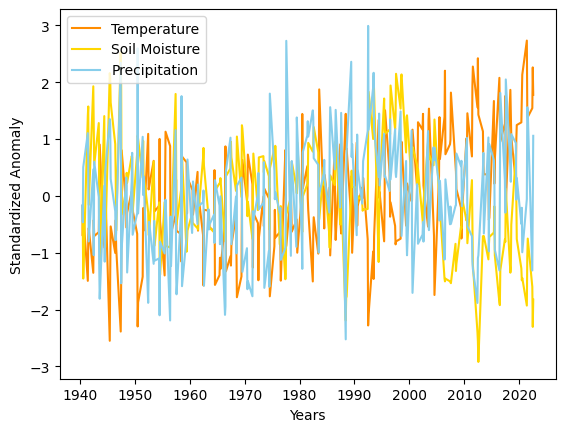

In [ ]:
#Plot summer monthly averages
plt.plot(T_anom_std.time,T_anom_std,color='darkorange',label='Temperature')
plt.plot(SM_anom_std.time,SM_anom_std,color='gold',label='Soil Moisture')
plt.plot(P_anom_std.time,P_anom_std,color='skyblue',label='Precipitation')
#plt.plot(np.arange(1940,2023),E_anom_std.groupby('time.year').mean(),color='Purple',label='Coupling')
#plt.bar(P_anom_std.time,P_anom_std)
plt.xlabel('Years')
plt.ylabel('Standardized Anomaly')
plt.legend()
#plt.xlim([1940,2023])

In [ ]:
#Calculate energy anomaly
E=H_anom_std-Hp_anom_std
SMT=(E.groupby('time.year').mean())*(T_anom_std.groupby('time.year').mean())
#[E,T_anom_std,SMT]

<BarContainer object of 83 artists>

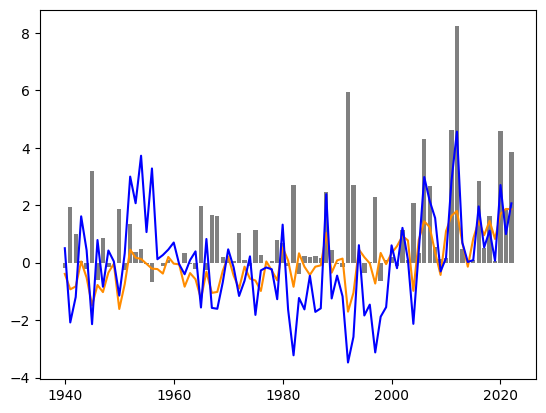

In [ ]:
#plot stnadardized temperature anomaly and energy anomaly, soil moisture temperature coupling
plt.plot(np.arange(1940,2023),T_anom_std.groupby('time.year').mean(),color='darkorange',label='Temperature')
plt.plot(np.arange(1940,2023),E.groupby('time.year').mean(),color='blue',label='Energy')
plt.bar(np.arange(1940,2023),SMT,color='grey',label='Coupling')

In [ ]:
#different tresholds to consider it a drought
#Identify moderate drought:
threshmin=-1; threshmax=-2
drys_comp = SMas.where((P_anom_std<threshmin) & (P_anom_std>threshmax)).mean(dim='time')
dryp_comp = Pas.where((P_anom_std<threshmin) & (P_anom_std>threshmax)).mean(dim='time')
CPp_comp = Cp.where((P_anom_std<threshmin) & (P_anom_std>threshmax)).mean(dim='time')
hotp_comp= Tas.where((P_anom_std<threshmin) & (P_anom_std>threshmax)).mean(dim='time')

In [ ]:
#Identify non-drought:
thresh=0
wdrys_comp = SMas.where(P_anom_std>thresh).mean(dim='time')
wdryp_comp = Pas.where(P_anom_std>thresh).mean(dim='time')
wCPp_comp = Cp.where(P_anom_std>thresh).mean(dim='time')
whotp_comp= Tas.where(P_anom_std>thresh).mean(dim='time')

In [ ]:
#Identify extreme drought:
thresh= threshmax
edrys_comp = SMas.where(P_anom_std<thresh).mean(dim='time')
edryp_comp = Pas.where(P_anom_std<thresh).mean(dim='time')
eCPp_comp = Cp.where(P_anom_std<thresh).mean(dim='time')
ehotp_comp= Tas.where(P_anom_std<thresh).mean(dim='time')

In [ ]:
drys = SMas.where((P_anom_std<threshmin) & (P_anom_std>threshmax))
dryp = Pas.where((P_anom_std<threshmin) & (P_anom_std>threshmax))
CPp = Cp.where((P_anom_std<threshmin) & (P_anom_std>threshmax))
hotp= Tas.where((P_anom_std<threshmin) & (P_anom_std>threshmax))
edrys = SMas.where(P_anom_std<thresh)
edryp = Pas.where(P_anom_std<thresh)
eCPp = Cp.where(P_anom_std<thresh)
ehotp= Tas.where(P_anom_std<thresh)
dryp

<xarray.DataArray 'tp' (time: 249, latitude: 121, longitude: 261)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -130.0 -129.8 -129.5 ... -65.5 -65.25 -65.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * time         (time) datetime64[ns] 1940-06-01 1940-07-01 ... 2022-08-01
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    month        (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 ... 7 8 6 7 8 6 7 8 6 7 8

In [ ]:
drycount=P_anom_std.where((P_anom_std<threshmin) & (P_anom_std>threshmax))#.count(dim='time')
edrycount=P_anom_std.where(P_anom_std<thresh).count(dim='time')
drycount#,edrycount

<xarray.DataArray 'tp' (time: 249)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan, -1.0437979,        nan,        nan,
       -1.2496219, -1.8093172,        nan, -1.157378 ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, -1.5381166,        nan,        nan,
              nan, -1.3479931,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, -1.8819625, -1.355522 ,        nan, -1.1952969,
              nan, -1.1401643, -1.1001469,        nan,        nan,
       -1.0137471,        nan,        nan,        nan,        nan,
       -1.234422 ,        nan, -1.2772167, -1.7312578,        nan,
              nan, -1.5889833,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, -1.5811619,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, -1.9449232,
              nan,        nan,        nan,        nan,        nan,
       -1.0111052,        nan,        nan,        nan, -1.3375525,
              nan, -1.6415565, -1.4990056, -1.7658226,        nan,
              nan,        nan,        nan,        nan,        nan,
...
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, -1.0448039,
              nan,        nan, -1.7063702,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, -1.1210927, -1.045805 ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, -1.1473355,
       -1.2810776, -1.8835063, -1.0946335, -1.0468129,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, -1.3109268,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, -1.3120036,        nan,        nan], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1940-06-01 1940-07-01 ... 2022-08-01
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    month        (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 ... 7 8 6 7 8 6 7 8 6 7 8

In [ ]:
Pas.where((P_anom_std<threshmin) & (P_anom_std>threshmax)).dropna('time', how='all')
Pas.where(P_anom_std<thresh).dropna('time', how='all')

<xarray.DataArray 'tp' (time: 4, latitude: 121, longitude: 261)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -130.0 -129.8 -129.5 ... -65.5 -65.25 -65.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * time         (time) datetime64[ns] 1954-07-01 1956-06-01 ... 1988-06-01
    spatial_ref  (time) int64 0 0 0 0
    month        (time) int64 7 6 6 6

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'Extreme Droughts')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


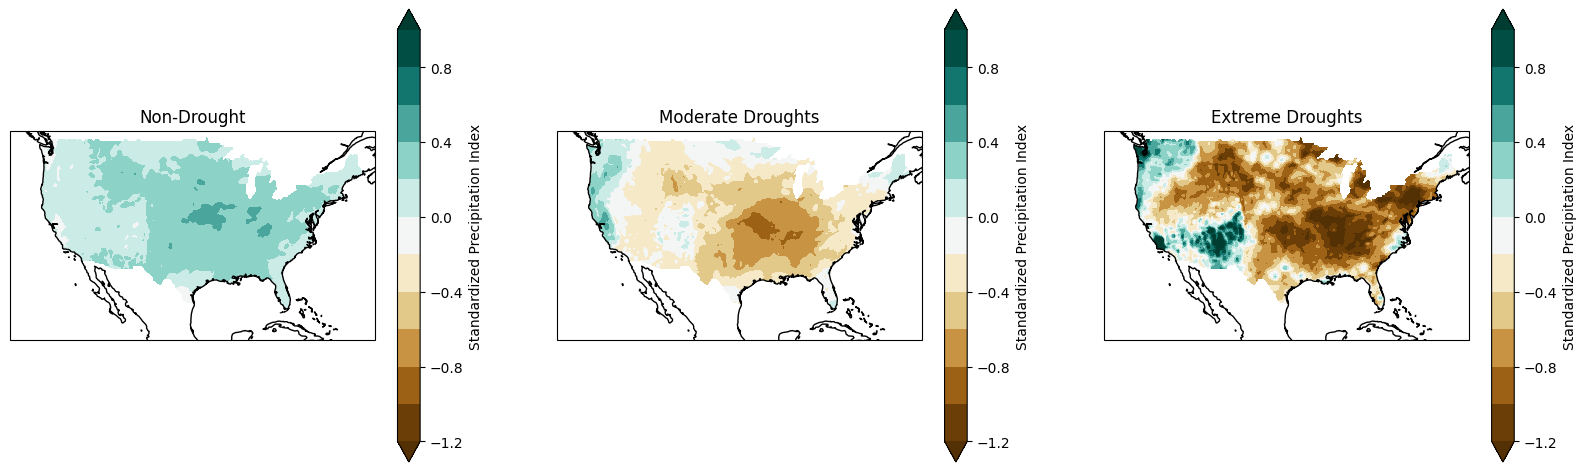

In [ ]:
#Drought comparison: precip
levels=np.arange(-1.2,1.2,0.2)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(wdryp_comp.longitude, wdryp_comp.latitude, wdryp_comp, cmap='BrBG',levels=levels,vcenter=0, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Precipitation Index')
ax.set_title('Non-Drought')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(dryp_comp.longitude, dryp_comp.latitude, dryp_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Precipitation Index')
ax.set_title('Moderate Droughts')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(edryp_comp.longitude, edryp_comp.latitude, edryp_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Standardized Precipitation Index')
ax2.set_title('Extreme Droughts')

Text(0.5, 1.0, 'Extreme Droughts')

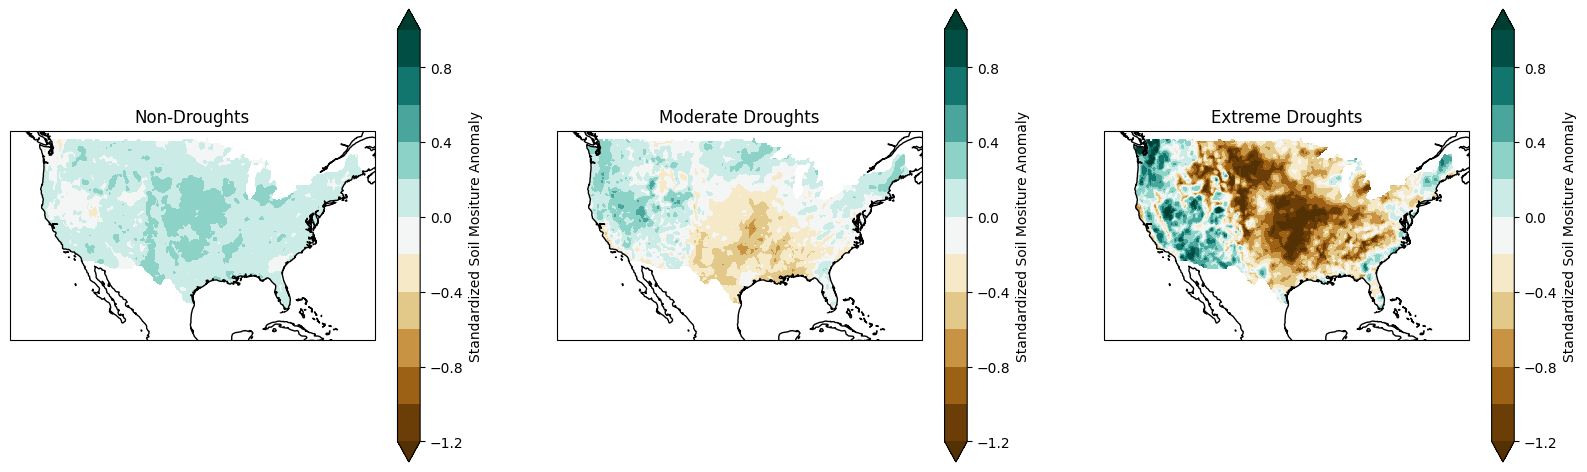

In [ ]:
#Drought comparison: soil moisture
levels=np.arange(-1.2,1.2,0.2)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(wdrys_comp.longitude, wdrys_comp.latitude, wdrys_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
ax.set_title('Non-Droughts')
cb.set_label('Standardized Soil Mositure Anomaly')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(drys_comp.longitude, drys_comp.latitude, drys_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
ax.set_title('Moderate Droughts')
cb.set_label('Standardized Soil Mositure Anomaly')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(edrys_comp.longitude, edrys_comp.latitude, edrys_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Standardized Soil Mositure Anomaly')
ax2.set_title('Extreme Droughts')

Text(0.5, 1.0, 'Extreme Droughts')

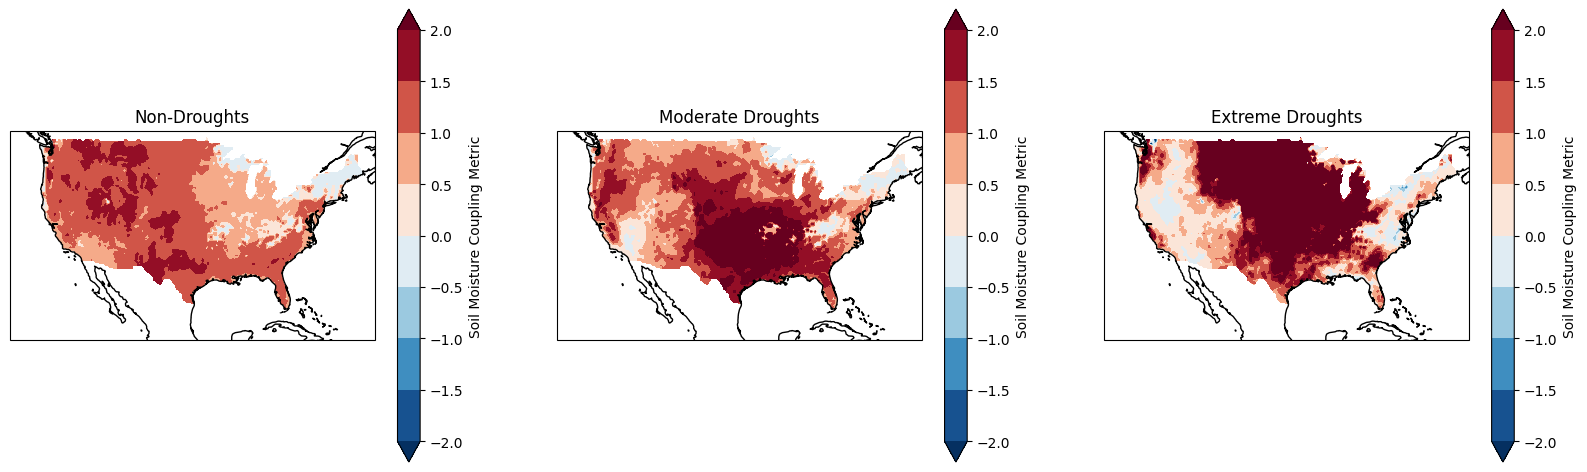

In [ ]:
#Drought comparison: CP
levels=np.arange(-2,2.2,0.5)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(wCPp_comp.longitude, wCPp_comp.latitude, wCPp_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Soil Moisture Coupling Metric')
ax.set_title('Non-Droughts')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(CPp_comp.longitude, CPp_comp.latitude, CPp_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Soil Moisture Coupling Metric')
ax.set_title('Moderate Droughts')
#cb.set_label('Standardized Precipitation Index')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(eCPp_comp.longitude, eCPp_comp.latitude, eCPp_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Soil Moisture Coupling Metric')
ax2.set_title('Extreme Droughts')

Text(0.5, 1.0, 'Extreme Droughts')

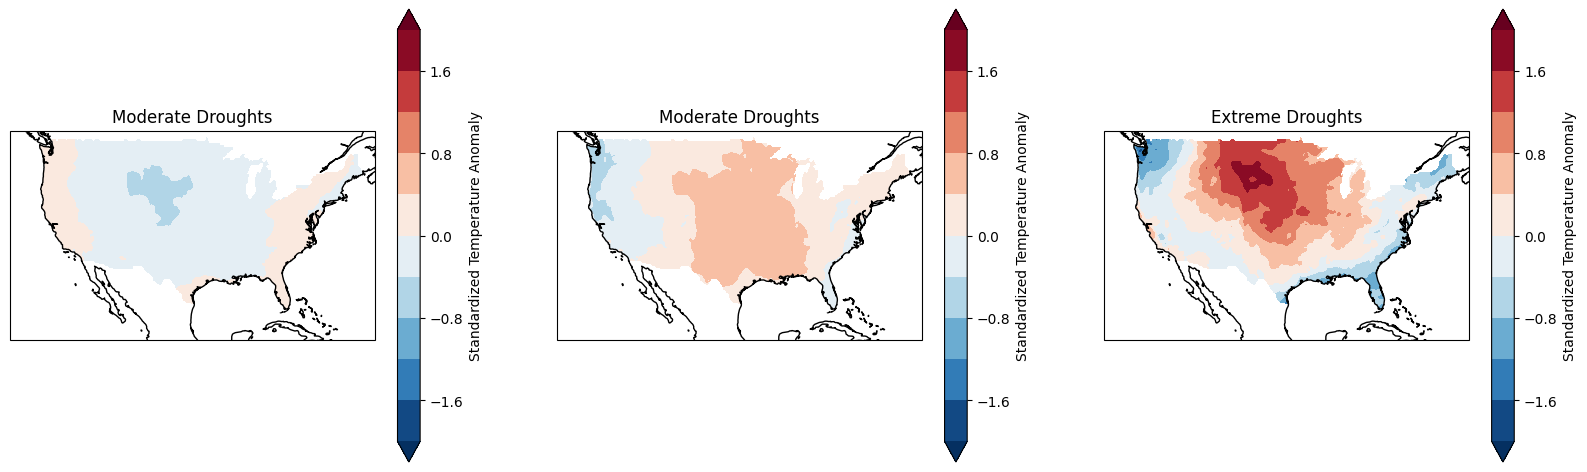

In [ ]:
#Drought comparison: T
levels=np.arange(-2,2.4,0.4)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(whotp_comp.longitude, whotp_comp.latitude, whotp_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Temperature Anomaly')
ax.set_title('Moderate Droughts')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(hotp_comp.longitude, hotp_comp.latitude, hotp_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Temperature Anomaly')

ax.set_title('Moderate Droughts')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(ehotp_comp.longitude, ehotp_comp.latitude, ehotp_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Standardized Temperature Anomaly')

ax2.set_title('Extreme Droughts')

In [ ]:
SM1=SMas.sel(time=slice('1940-01-01','1999-12-31'))
SM2=SMas.sel(time=slice('2000-01-01','2022-12-31'))

In [ ]:
##calculation of joint distribution
bins = np.linspace(-4, 4, 50)
hp1=histogram(Tas.sel(time=slice('1940-01-01','1962-12-31')), Pas.sel(time=slice('1940-01-01','1962-12-31')), bins=[bins, bins])
hp2=histogram(Tas.sel(time=slice('2000-01-01','2022-12-31')), Pas.sel(time=slice('2000-01-01','2022-12-31')), bins=[bins, bins])
hs1=histogram(Tas.sel(time=slice('1940-01-01','1962-12-31')), SMas.sel(time=slice('1940-01-01','1962-12-31')), bins=[bins, bins])
hs2=histogram(Tas.sel(time=slice('2000-01-01','2022-12-31')), SMas.sel(time=slice('2000-01-01','2022-12-31')), bins=[bins, bins])
he1=histogram(SMas.sel(time=slice('1940-01-01','1962-12-31')), Pas.sel(time=slice('1940-01-01','1962-12-31')), bins=[bins, bins])
he2=histogram(SMas.sel(time=slice('2000-01-01','2022-12-31')), Pas.sel(time=slice('2000-01-01','2022-12-31')), bins=[bins, bins])

Text(0, 0.5, 'Energy Anomaly')

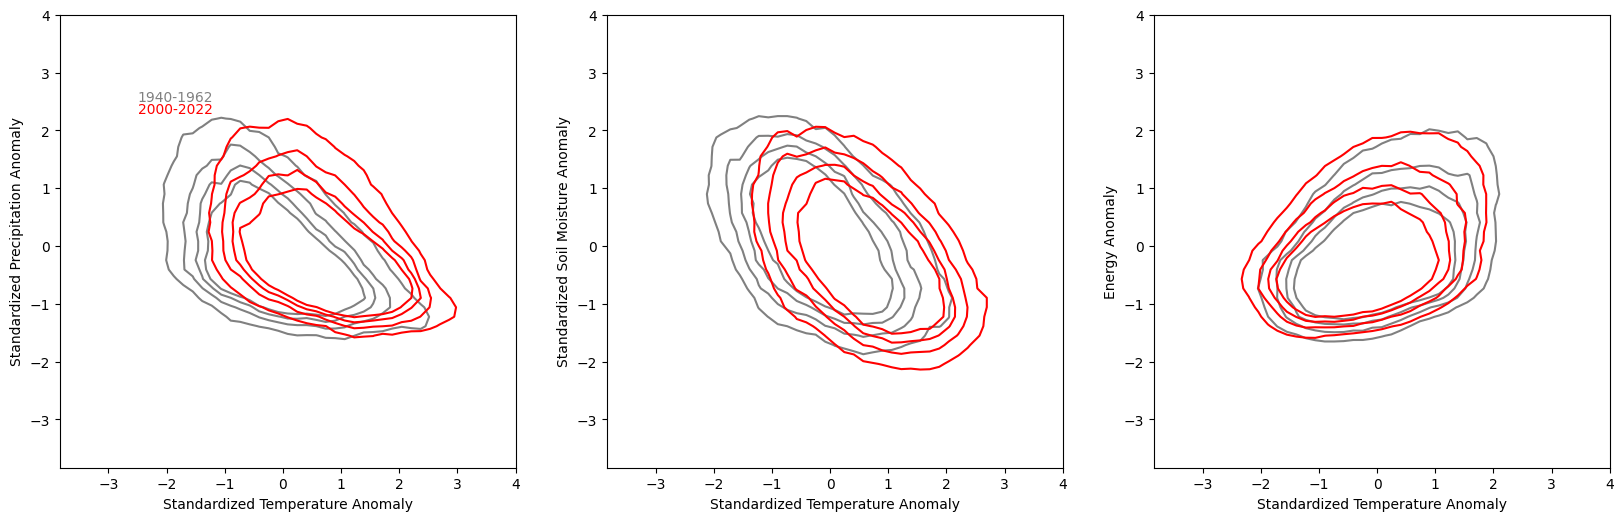

In [ ]:
## plotting joint distribution
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1)
cs1=ax.contour(bins[1:],bins[1:],hp1.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],hp2.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Standardized Precipitation Anomaly')
#ax.legend([cs1,cs2],['1940-1999','-2022'])
plt.text(-2.5, 2.5, r'1940-1962',color='grey')
plt.text(-2.5, 2.3, r'2000-2022',color='red')
ax = fig.add_subplot(3,3,2)
cs1=ax.contour(bins[1:],bins[1:],hs1.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],hs2.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Standardized Soil Moisture Anomaly')
ax = fig.add_subplot(3,3,3)
cs1=ax.contour(bins[1:],bins[1:],he1.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],he2.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Energy Anomaly')
#plt.text(-2.5, 2.5, r'1940-1980',color='grey')
#plt.text(-2.5, 2.3, r'1981-2022',color='red')

Text(0, 0.5, 'Standardized Soil Moisture Anomaly')

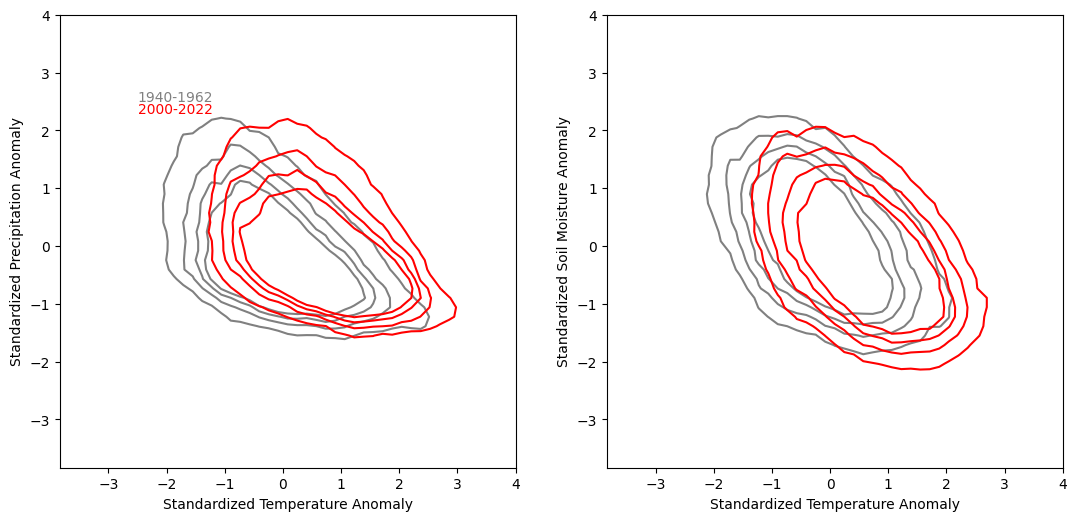

In [ ]:
#Same fig as above but just first two plots:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1)
cs1=ax.contour(bins[1:],bins[1:],hp1.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],hp2.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Standardized Precipitation Anomaly')
#ax.legend([cs1,cs2],['1940-1999','-2022'])
plt.text(-2.5, 2.5, r'1940-1962',color='grey')
plt.text(-2.5, 2.3, r'2000-2022',color='red')
ax = fig.add_subplot(3,3,2)
cs1=ax.contour(bins[1:],bins[1:],hs1.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],hs2.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Standardized Soil Moisture Anomaly')
# ax = fig.add_subplot(3,3,3)
# cs1=ax.contour(bins[1:],bins[1:],he1.T,colors='grey',levels=[500,1000,1500,2000])
# cs2=ax.contour(bins[1:],bins[1:],he2.T,colors='red',levels=[500,1000,1500,2000])
# ax.set_xlabel('Standardized Temperature Anomaly')
# ax.set_ylabel('Energy Anomaly')
#plt.text(-2.5, 2.5, r'1940-1980',color='grey')
#plt.text(-2.5, 2.3, r'1981-2022',color='red')

In [ ]:
#Redo analysis above with different date delineation:
bins = np.linspace(-4, 4, 50)
hp1_full=histogram(Tas.sel(time=slice('1940-01-01','1980-12-31')), Pas.sel(time=slice('1940-01-01','1980-12-31')), bins=[bins, bins])
hp2_full=histogram(Tas.sel(time=slice('1981-01-01','2022-12-31')), Pas.sel(time=slice('1981-01-01','2022-12-31')), bins=[bins, bins])
hs1_full=histogram(Tas.sel(time=slice('1940-01-01','1980-12-31')), SMas.sel(time=slice('1940-01-01','1980-12-31')), bins=[bins, bins])
hs2_full=histogram(Tas.sel(time=slice('1981-01-01','2022-12-31')), SMas.sel(time=slice('1981-01-01','2022-12-31')), bins=[bins, bins])
he1_full=histogram(SMas.sel(time=slice('1940-01-01','1980-12-31')), Pas.sel(time=slice('1940-01-01','1980-12-31')), bins=[bins, bins])
he2_full=histogram(SMas.sel(time=slice('1981-01-01','2022-12-31')), Pas.sel(time=slice('1981-01-01','2022-12-31')), bins=[bins, bins])

Text(0, 0.5, 'Standardized Soil Moisture Anomaly')

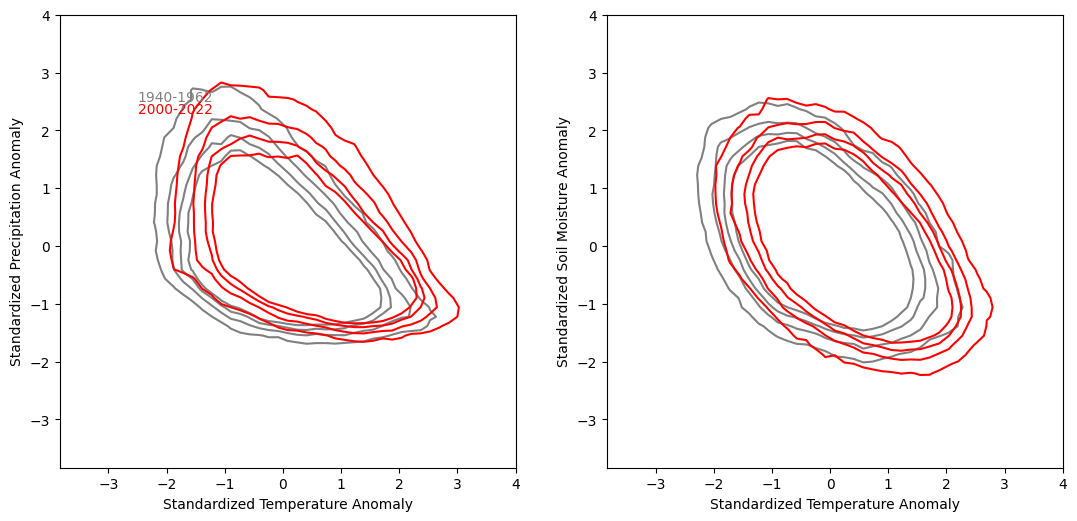

In [ ]:
#Same fig as above but just first two plots:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1)
cs1=ax.contour(bins[1:],bins[1:],hp1_full.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],hp2_full.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Standardized Precipitation Anomaly')
#ax.legend([cs1,cs2],['1940-1999','-2022'])
plt.text(-2.5, 2.5, r'1940-1962',color='grey')
plt.text(-2.5, 2.3, r'2000-2022',color='red')
ax = fig.add_subplot(3,3,2)
cs1=ax.contour(bins[1:],bins[1:],hs1_full.T,colors='grey',levels=[500,1000,1500,2000])
cs2=ax.contour(bins[1:],bins[1:],hs2_full.T,colors='red',levels=[500,1000,1500,2000])
ax.set_xlabel('Standardized Temperature Anomaly')
ax.set_ylabel('Standardized Soil Moisture Anomaly')
# ax = fig.add_subplot(3,3,3)
# cs1=ax.contour(bins[1:],bins[1:],he1.T,colors='grey',levels=[500,1000,1500,2000])
# cs2=ax.contour(bins[1:],bins[1:],he2.T,colors='red',levels=[500,1000,1500,2000])
# ax.set_xlabel('Standardized Temperature Anomaly')
# ax.set_ylabel('Energy Anomaly')
#plt.text(-2.5, 2.5, r'1940-1980',color='grey')
#plt.text(-2.5, 2.3, r'1981-2022',color='red')

## Extreme heat, heat, non-heat:

In [ ]:
#different thresholds to consider it extreme heat/heat/non-heat
#Identify moderate heat:
threshmin=1; threshmax=2
hotsm_comp = SMas.where((T_anom_std>threshmin) & (T_anom_std<threshmax)).mean(dim='time')
hotp_comp = Pas.where((T_anom_std>threshmin) & (T_anom_std<threshmax)).mean(dim='time')
hotCP_comp = Cp.where((T_anom_std>threshmin) & (T_anom_std<threshmax)).mean(dim='time')
hotT_comp= Tas.where((T_anom_std>threshmin) & (T_anom_std<threshmax)).mean(dim='time')

In [ ]:
#Identify non-heat:
thresh=0
nhotsm_comp= SMas.where(T_anom_std<thresh).mean(dim='time')
nhotp_comp = Pas.where(T_anom_std<thresh).mean(dim='time')
nhotCP_comp = Cp.where(T_anom_std<thresh).mean(dim='time')
nhotT_comp= Tas.where(T_anom_std<thresh).mean(dim='time')


In [ ]:
#Identify extreme heat:
thresh= threshmax
ehotsm_comp = SMas.where(T_anom_std>thresh).mean(dim='time')
ehotp_comp = Pas.where(T_anom_std>thresh).mean(dim='time')
ehotCP_comp = Cp.where(T_anom_std>thresh).mean(dim='time')
ehotT_comp= Tas.where(T_anom_std>thresh).mean(dim='time')

In [ ]:
#REDO

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'Extreme Warming')

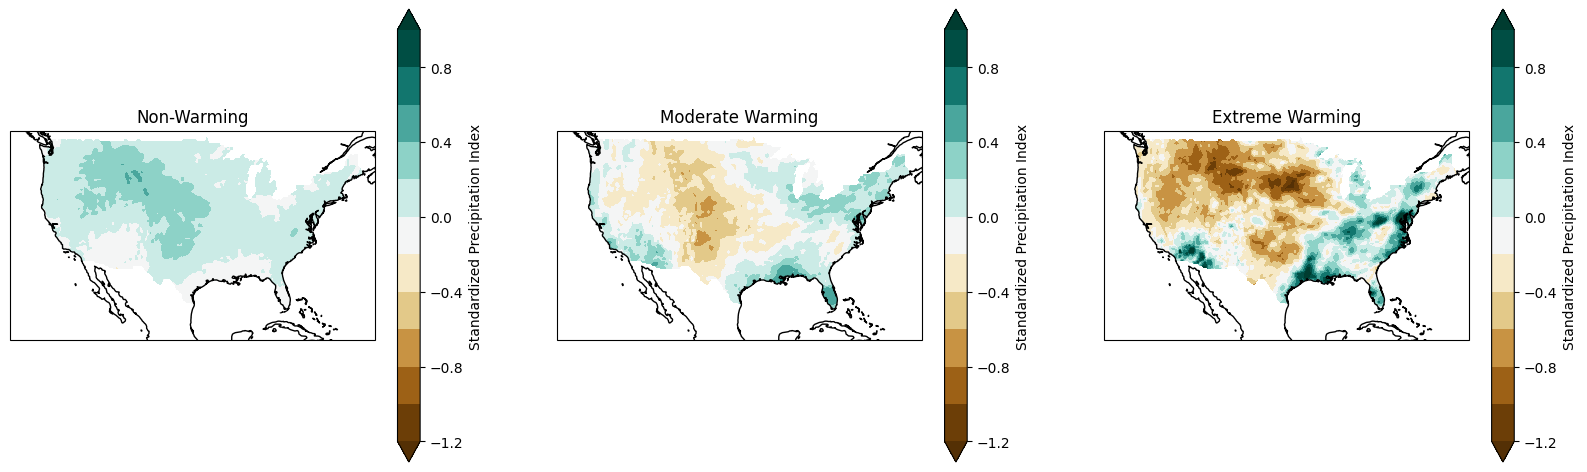

In [ ]:
#Heat comparison: precip
levels=np.arange(-1.2,1.2,0.2)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(nhotp_comp.longitude, nhotp_comp.latitude, nhotp_comp, cmap='BrBG',levels=levels,vcenter=0, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Precipitation Index')
ax.set_title('Non-Warming')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(hotp_comp.longitude, hotp_comp.latitude, hotp_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Precipitation Index')
ax.set_title('Moderate Warming')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(ehotp_comp.longitude, ehotp_comp.latitude, ehotp_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Standardized Precipitation Index')
ax2.set_title('Extreme Warming')

Text(0.5, 1.0, 'Extreme Warming')

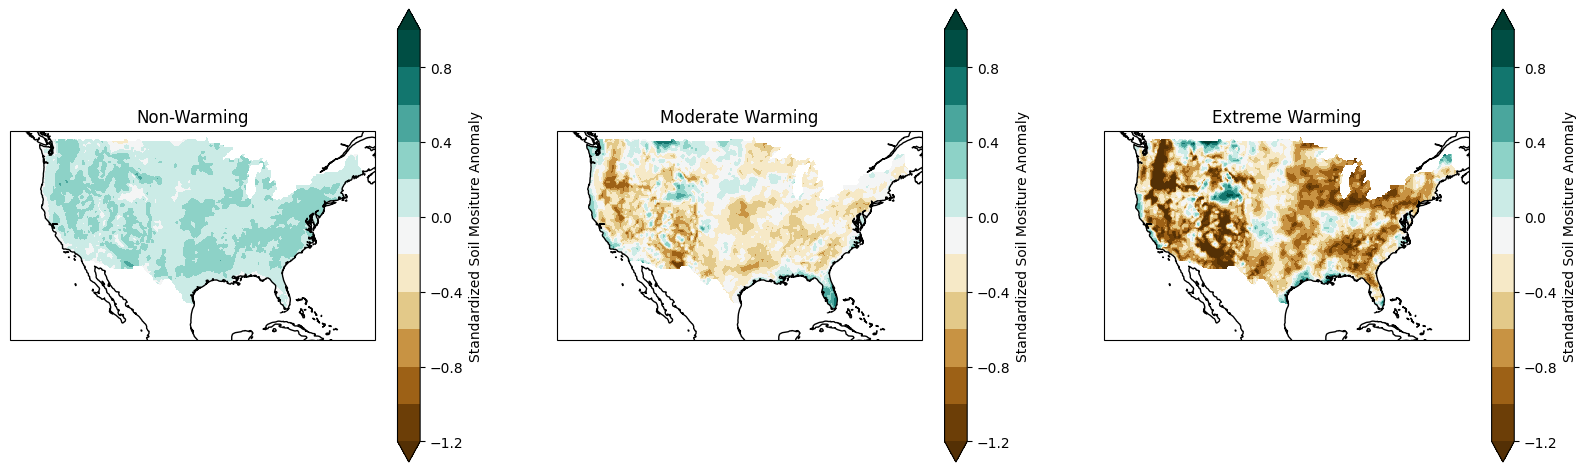

In [ ]:
#Heat comparison: soil moisture
levels=np.arange(-1.2,1.2,0.2)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(nhotsm_comp.longitude, nhotsm_comp.latitude, nhotsm_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
ax.set_title('Non-Warming')
cb.set_label('Standardized Soil Mositure Anomaly')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(hotsm_comp.longitude, hotsm_comp.latitude, hotsm_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
ax.set_title('Moderate Warming')
cb.set_label('Standardized Soil Mositure Anomaly')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(ehotsm_comp.longitude, ehotsm_comp.latitude, ehotsm_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Standardized Soil Mositure Anomaly')
ax2.set_title('Extreme Warming')

Text(0.5, 1.0, 'Extreme Warming')

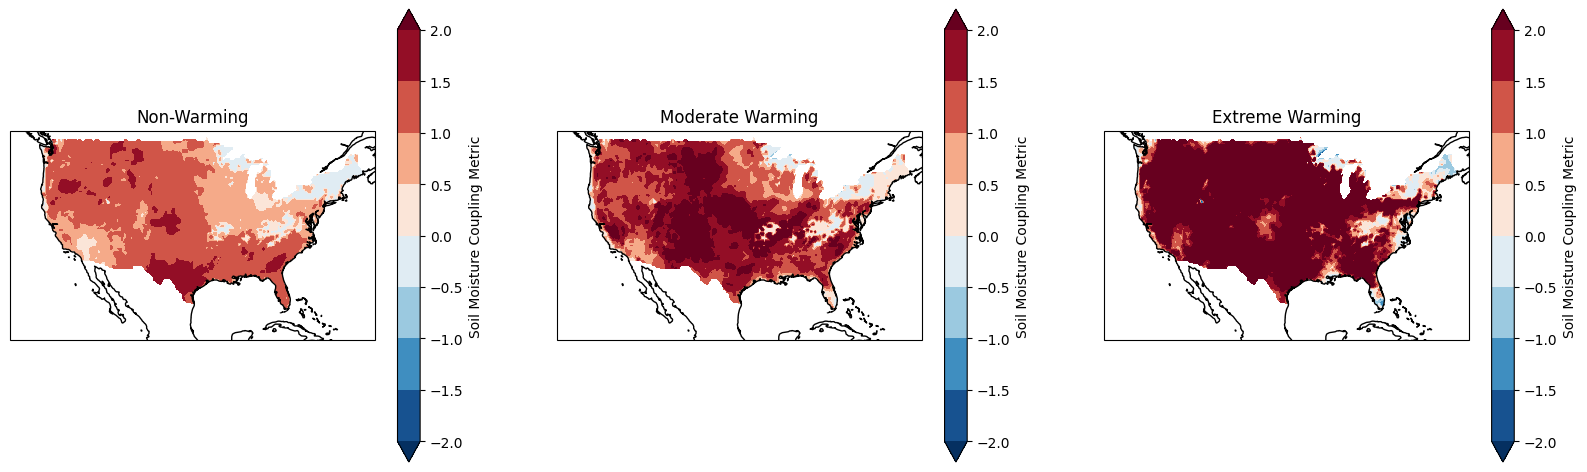

In [ ]:
#Heat comparison: CP
levels=np.arange(-2,2.2,0.5)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(nhotCP_comp.longitude, nhotCP_comp.latitude, nhotCP_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Soil Moisture Coupling Metric')
ax.set_title('Non-Warming')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(hotCP_comp.longitude, hotCP_comp.latitude, hotCP_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Soil Moisture Coupling Metric')
ax.set_title('Moderate Warming')
#cb.set_label('Standardized Precipitation Index')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(ehotCP_comp.longitude, ehotCP_comp.latitude, ehotCP_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Soil Moisture Coupling Metric')
ax2.set_title('Extreme Warming')

Text(0.5, 1.0, 'Extreme Warming')

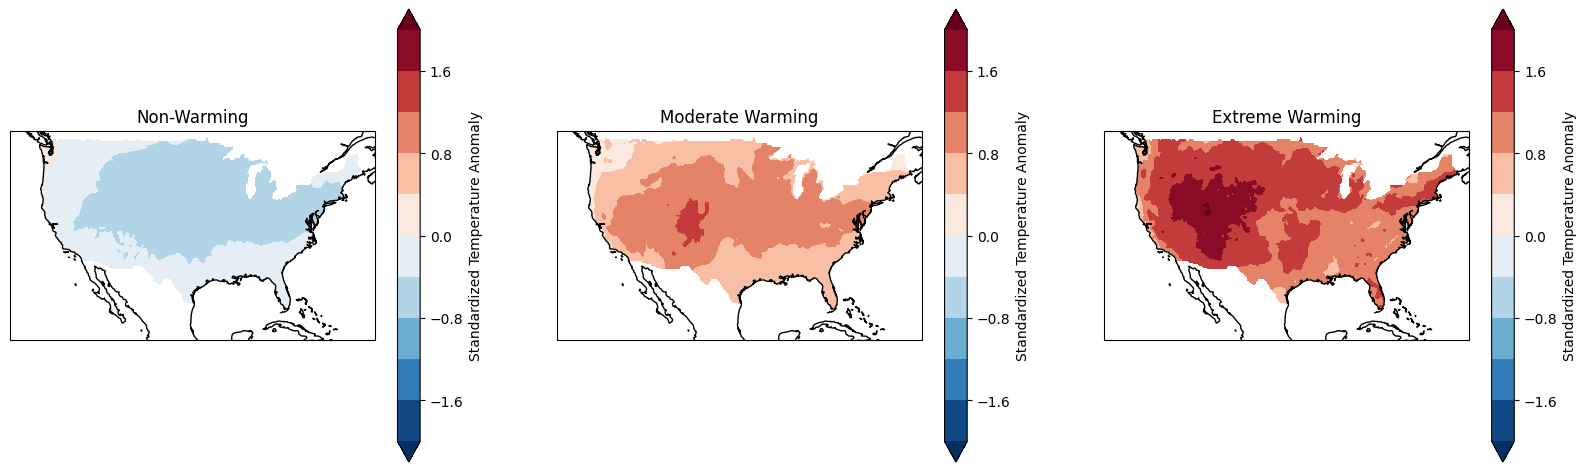

In [ ]:
#Drought comparison: T
levels=np.arange(-2,2.4,0.4)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3,3,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(nhotT_comp.longitude, nhotT_comp.latitude, nhotT_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Temperature Anomaly')
ax.set_title('Non-Warming')
ax = fig.add_subplot(3,3,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(hotT_comp.longitude, hotT_comp.latitude, hotT_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1)
cb.set_label('Standardized Temperature Anomaly')

ax.set_title('Moderate Warming')
ax2 = fig.add_subplot(3,3,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(ehotT_comp.longitude, ehotT_comp.latitude, ehotT_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2)
cb.set_label('Standardized Temperature Anomaly')

ax2.set_title('Extreme Warming')